In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
H = np.array([[1.0, 0.0],
              [0.0, 50.0]])

def cost_func(v):
    return 0.5 * v.T @ H @ v

def grad(v):
    return H @ v

In [3]:
def gradient_descent(theta0, lr, iters):
    path = [theta0.copy()]
    theta = theta0.copy()

    for i in range(iters):
        g = grad(theta)
        theta = theta - lr * g
        path.append(theta.copy())

    return np.array(path)

In [4]:
theta_test = np.array([1.0, 2.0])
g = grad(theta_test)

print("theta:", theta_test)
print("Gradient:", g)


theta: [1. 2.]
Gradient: [  1. 100.]


In [5]:
theta_test = np.array([1.0, 2.0])
lr = 0.05

g = grad(theta_test)
theta_next = theta_test - lr * g

print("theta_start:", theta_test)
print("gradient:", g)
print("theta_next:", theta_next)

theta_start: [1. 2.]
gradient: [  1. 100.]
theta_next: [ 0.95 -3.  ]


In [6]:
def newton_method(theta0, iters):
    path = [theta0.copy()]
    theta = theta0.copy()
    H_inv = np.linalg.inv(H)

    for i in range(iters):
        g = grad(theta)
        theta = theta - H_inv @ g
        path.append(theta.copy())

    return np.array(path)

In [7]:
theta_test = np.array([1.0, 2.0])
newton_path = newton_method(theta_test, iters=1)

print("theta_start:", theta_test)
print("theta_after_newton:", newton_path[-1])

theta_start: [1. 2.]
theta_after_newton: [0. 0.]


In [8]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)

Z = 0.5 * (H[0,0]*X**2 + H[1,1]*Y**2)

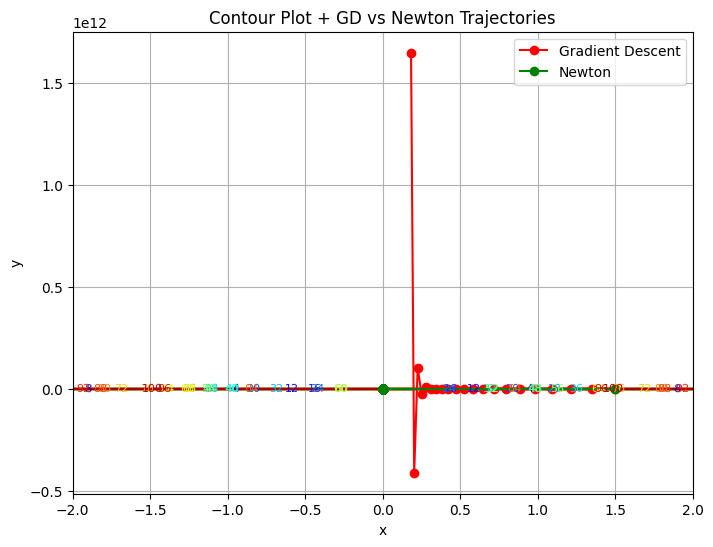

In [9]:
plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=30, cmap="jet")
plt.clabel(contours, inline=True, fontsize=8)
theta0 = np.array([1.5, 1.5])

gd_path = gradient_descent(theta0, lr=0.1, iters=20)
newton_path = newton_method(theta0, iters=300)
plt.plot(gd_path[:, 0], gd_path[:, 1], 'o-', color='red', label='Gradient Descent')
plt.plot(newton_path[:, 0], newton_path[:, 1], 'o-', color='green', label='Newton')
plt.title("Contour Plot + GD vs Newton Trajectories")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def conjugate_gradient(theta0, iters):
    path = [theta0.copy()]
    theta = theta0.copy()
    r = -grad(theta)
    p = r.copy()
    
    for i in range(iters):
        alpha = (r.T @ r) / (p.T @ H @ p)
        theta = theta + alpha * p
        r_new = r - alpha * H @ p
        beta = (r_new.T @ r_new) / (r.T @ r)
        p = r_new + beta * p
        r = r_new
        path.append(theta.copy())
    
    return np.array(path)

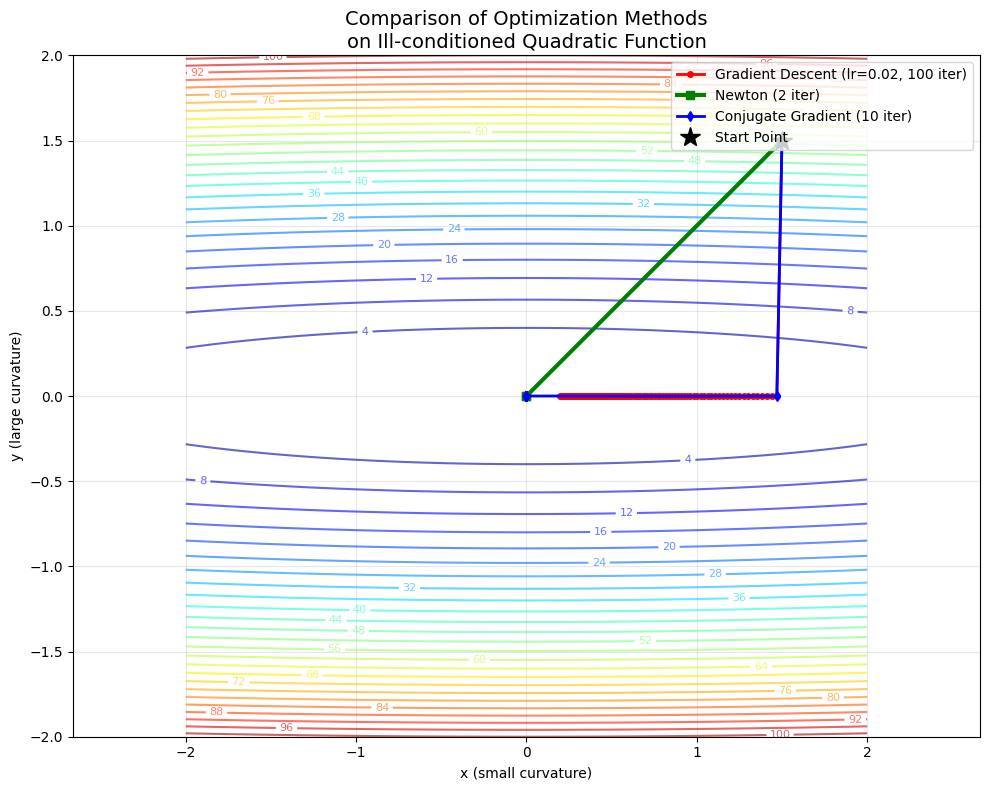

Method Comparison:
Gradient Descent - Final point: [0.19892933 0.        ], Cost: 0.019786
Newton Method    - Final point: [0. 0.], Cost: 0.000000
Conjugate Grad   - Final point: [-1.72723371e-77 -9.77126366e-17], Cost: 0.000000

Optimal point (global minimum): [0, 0], Cost: 0


In [11]:
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
Z = 0.5 * (H[0,0]*X**2 + H[1,1]*Y**2)

plt.figure(figsize=(10, 8))
contours = plt.contour(X, Y, Z, levels=30, cmap="jet", alpha=0.6)
plt.clabel(contours, inline=True, fontsize=8)
theta0 = np.array([1.5, 1.5])

gd_path = gradient_descent(theta0, lr=0.02, iters=100)
newton_path = newton_method(theta0, iters=2)
cg_path = conjugate_gradient(theta0, iters=10)

plt.plot(gd_path[:, 0], gd_path[:, 1], 'o-', color='red', 
         linewidth=2, markersize=4, label='Gradient Descent (lr=0.02, 100 iter)')
plt.plot(newton_path[:, 0], newton_path[:, 1], 's-', color='green', 
         linewidth=3, markersize=6, label='Newton (2 iter)')
plt.plot(cg_path[:, 0], cg_path[:, 1], 'd-', color='blue', 
         linewidth=2, markersize=5, label='Conjugate Gradient (10 iter)')

plt.plot(theta0[0], theta0[1], 'k*', markersize=15, label='Start Point')

plt.title("Comparison of Optimization Methods\non Ill-conditioned Quadratic Function", fontsize=14)
plt.xlabel("x (small curvature)")
plt.ylabel("y (large curvature)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

print("Method Comparison:")
print(f"Gradient Descent - Final point: {gd_path[-1]}, Cost: {cost_func(gd_path[-1]):.6f}")
print(f"Newton Method    - Final point: {newton_path[-1]}, Cost: {cost_func(newton_path[-1]):.6f}")
print(f"Conjugate Grad   - Final point: {cg_path[-1]}, Cost: {cost_func(cg_path[-1]):.6f}")
print(f"\nOptimal point (global minimum): [0, 0], Cost: 0")

In [12]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Dataset Summary:")
print(f"Total samples: {X.shape[0]}, Features: {X.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Malignant (0): {np.sum(y==0)}, Benign (1): {np.sum(y==1)}")

Dataset Summary:
Total samples: 569, Features: 30
Training samples: 455
Test samples: 114
Class distribution: [212 357]
Malignant (0): 212, Benign (1): 357


In [22]:
class ShallowMLP:
    def __init__(self, input_dim, hidden_dim=5, output_dim=1):
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.sigmoid(self.z1)
        
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        
        return self.a2
    
    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def compute_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        loss = -np.mean(y_true * np.log(y_pred + 1e-8) + 
                       (1 - y_true) * np.log(1 - y_pred + 1e-8))
        return loss
    
    def predict(self, X, threshold=0.5):
        prob = self.forward(X)
        return (prob >= threshold).astype(int)
    
    def get_parameters_vector(self):
        return np.concatenate([
            self.W1.flatten(),
            self.b1.flatten(),
            self.W2.flatten(),
            self.b2.flatten()
        ])
    
    def set_parameters_vector(self, theta):
        idx = 0
        
        size = self.input_dim * self.hidden_dim
        self.W1 = theta[idx:idx+size].reshape(self.input_dim, self.hidden_dim)
        idx += size
        
        size = self.hidden_dim
        self.b1 = theta[idx:idx+size].reshape(1, self.hidden_dim)
        idx += size
        
        size = self.hidden_dim * 1
        self.W2 = theta[idx:idx+size].reshape(self.hidden_dim, 1)
        idx += size
        
        size = 1
        self.b2 = theta[idx:idx+size].reshape(1, 1)
    
    def get_num_parameters(self):
        return (self.input_dim * self.hidden_dim + self.hidden_dim + 
                self.hidden_dim * 1 + 1)

input_dim = X_train.shape[1]
hidden_dim = 5
model = ShallowMLP(input_dim, hidden_dim)

print("\n" + "="*50)
print("Model Architecture:")
print(f"Input layer: {input_dim} neurons (features)")
print(f"Hidden layer: {hidden_dim} neurons")
print(f"Output layer: 1 neuron (binary classification)")
print(f"Activation: Sigmoid (both layers)")
print(f"Loss function: Binary Cross-Entropy")

total_params = model.get_num_parameters()
print(f"\nTotal parameters: {total_params}")
print(f"Parameters breakdown:")
print(f"  W1: {input_dim} × {hidden_dim} = {input_dim * hidden_dim}")
print(f"  b1: {hidden_dim}")
print(f"  W2: {hidden_dim} × 1 = {hidden_dim}")
print(f"  b2: 1")

if total_params < 500:
    print(f"✓ Model satisfies requirement: {total_params} < 500 parameters")
else:
    print(f"✗ Model exceeds 500 parameters: {total_params}")


Model Architecture:
Input layer: 30 neurons (features)
Hidden layer: 5 neurons
Output layer: 1 neuron (binary classification)
Activation: Sigmoid (both layers)
Loss function: Binary Cross-Entropy

Total parameters: 161
Parameters breakdown:
  W1: 30 × 5 = 150
  b1: 5
  W2: 5 × 1 = 5
  b2: 1
✓ Model satisfies requirement: 161 < 500 parameters


In [23]:
print("\n" + "="*50)
print("Testing forward pass...")
sample_idx = 0
X_sample = X_train[sample_idx:sample_idx+1]
y_sample = y_train[sample_idx:sample_idx+1]

output = model.forward(X_sample)
loss = model.compute_loss(output, y_sample.reshape(-1, 1))

print(f"Input shape: {X_sample.shape}")
print(f"Output probability: {output[0,0]:.4f}")
print(f"True label: {y_sample[0]}")
print(f"Loss for this sample: {loss:.4f}")

def gradient_check(model, X, y, epsilon=1e-7):
    theta_original = model.get_parameters_vector()
    
    param_idx = np.random.randint(0, len(theta_original))
    
    model.set_parameters_vector(theta_original.copy())
    loss_plus = model.compute_loss(model.forward(X), y.reshape(-1, 1))
    
    theta_minus = theta_original.copy()
    theta_minus[param_idx] -= epsilon
    model.set_parameters_vector(theta_minus)
    loss_minus = model.compute_loss(model.forward(X), y.reshape(-1, 1))
    
    grad_fd = (loss_plus - loss_minus) / (2 * epsilon)
    
    return grad_fd

print("\n" + "="*50)
print("Quick gradient check (finite differences):")
fd_grad = gradient_check(model, X_sample, y_sample)
print(f"Finite difference gradient: {fd_grad:.6e}")

print("\n" + "="*50)
print("Summary for Section 2.1:")
print("1. Dataset: Breast Cancer Wisconsin (30 features, binary classification)")
print("2. Model: Shallow MLP with 1 hidden layer (5 neurons)")
print(f"3. Total parameters: {total_params} (meets <500 requirement)")
print("4. Ready for optimization methods (GD, Newton, CG) in next step")


Testing forward pass...
Input shape: (1, 30)
Output probability: 0.4940
True label: 1
Loss for this sample: 0.7052

Quick gradient check (finite differences):
Finite difference gradient: -6.883505e-04

Summary for Section 2.1:
1. Dataset: Breast Cancer Wisconsin (30 features, binary classification)
2. Model: Shallow MLP with 1 hidden layer (5 neurons)
3. Total parameters: 161 (meets <500 requirement)
4. Ready for optimization methods (GD, Newton, CG) in next step


In [16]:
from scipy.optimize import minimize
import time
model_original = ShallowMLP(input_dim, hidden_dim)

def get_loss_grad_func(model, X, y):
    def loss_func(theta):
        model.set_parameters_vector(theta)
        y_pred = model.forward(X)
        loss = model.compute_loss(y_pred, y.reshape(-1, 1))
        return loss
    
    def grad_func(theta):
        model.set_parameters_vector(theta)
        
        y_pred = model.forward(X)
        m = X.shape[0]
        
        dz2 = y_pred - y.reshape(-1, 1)
        dW2 = (model.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        dz1 = (dz2 @ model.W2.T) * model.sigmoid_derivative(model.a1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        grad = np.concatenate([dW1.flatten(), db1.flatten(), 
                              dW2.flatten(), db2.flatten()])
        return grad
    
    return loss_func, grad_func

theta_init = model_original.get_parameters_vector()
print(f"Initial loss: {model_original.compute_loss(model_original.forward(X_train), y_train):.6f}")

results = {
    'SGD': {'loss_history': [], 'time_history': [], 'final_loss': None},
    'BFGS': {'loss_history': [], 'time_history': [], 'final_loss': None},
    'CG': {'loss_history': [], 'time_history': [], 'final_loss': None}
}


Initial loss: 0.693195


In [24]:
model_sgd = ShallowMLP(input_dim, hidden_dim)
model_sgd.set_parameters_vector(theta_init.copy())

lr = 0.0005
epochs = 1000
batch_size = 32
n_samples = X_train.shape[0]

start_time = time.time()
for epoch in range(epochs):
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    epoch_loss = 0
    for i in range(0, n_samples, batch_size):
        X_batch = X_shuffled[i:i+batch_size]
        y_batch = y_shuffled[i:i+batch_size].reshape(-1, 1)
        
        y_pred = model_sgd.forward(X_batch)
        
        m = X_batch.shape[0]
        dz2 = y_pred - y_batch
        dW2 = (model_sgd.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        
        dz1 = (dz2 @ model_sgd.W2.T) * model_sgd.sigmoid_derivative(model_sgd.a1)
        dW1 = (X_batch.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m
        
        model_sgd.W2 -= lr * dW2
        model_sgd.b2 -= lr * db2
        model_sgd.W1 -= lr * dW1
        model_sgd.b1 -= lr * db1
    
    if epoch % 10 == 0:
        y_pred_all = model_sgd.forward(X_train)
        loss = model_sgd.compute_loss(y_pred_all, y_train)
        elapsed = time.time() - start_time
        results['SGD']['loss_history'].append(loss)
        results['SGD']['time_history'].append(elapsed)
        if epoch % 100 == 0:
            print(f"  Epoch {epoch:4d}, Loss: {loss:.6f}, Time: {elapsed:.2f}s")

sgd_time = time.time() - start_time
final_loss = model_sgd.compute_loss(model_sgd.forward(X_train), y_train)
results['SGD']['final_loss'] = final_loss
print(f"SGD completed: {epochs} epochs, Final loss: {final_loss:.6f}, Time: {sgd_time:.2f}s")



  Epoch    0, Loss: 0.692934, Time: 0.01s
  Epoch  100, Loss: 0.674864, Time: 0.26s
  Epoch  200, Loss: 0.666756, Time: 0.47s
  Epoch  300, Loss: 0.662973, Time: 0.66s
  Epoch  400, Loss: 0.661419, Time: 0.88s
  Epoch  500, Loss: 0.661222, Time: 1.06s
  Epoch  600, Loss: 0.662143, Time: 1.24s
  Epoch  700, Loss: 0.664196, Time: 1.43s
  Epoch  800, Loss: 0.667518, Time: 1.59s
  Epoch  900, Loss: 0.672369, Time: 1.76s
SGD completed: 1000 epochs, Final loss: 0.678502, Time: 1.92s


In [26]:
model_bfgs = ShallowMLP(input_dim, hidden_dim)
model_bfgs.set_parameters_vector(theta_init.copy())

loss_func, grad_func = get_loss_grad_func(model_bfgs, X_train, y_train)

bfgs_loss_history = []
bfgs_time_history = []
start_time = time.time()

def bfgs_callback(theta):
    elapsed = time.time() - start_time
    loss = loss_func(theta)
    bfgs_loss_history.append(loss)
    bfgs_time_history.append(elapsed)

print("  Running BFGS optimization...")
result = minimize(loss_func, theta_init, method='BFGS', jac=grad_func,
                  callback=bfgs_callback, options={'maxiter': 500, 'disp': True})

bfgs_time = time.time() - start_time
model_bfgs.set_parameters_vector(result.x)
results['BFGS']['loss_history'] = bfgs_loss_history
results['BFGS']['time_history'] = bfgs_time_history
results['BFGS']['final_loss'] = result.fun
print(f"BFGS completed: {result.nit} iterations, Final loss: {result.fun:.6f}, Time: {bfgs_time:.2f}s")


  Running BFGS optimization...
Optimization terminated successfully.
         Current function value: 0.014626
         Iterations: 202
         Function evaluations: 213
         Gradient evaluations: 213
BFGS completed: 202 iterations, Final loss: 0.014626, Time: 0.39s


In [27]:
model_cg = ShallowMLP(input_dim, hidden_dim)
model_cg.set_parameters_vector(theta_init.copy())

loss_func, grad_func = get_loss_grad_func(model_cg, X_train, y_train)

cg_loss_history = []
cg_time_history = []
start_time = time.time()

def cg_callback(theta):
    elapsed = time.time() - start_time
    loss = loss_func(theta)
    cg_loss_history.append(loss)
    cg_time_history.append(elapsed)

print("  Running Conjugate Gradient optimization...")
result_cg = minimize(loss_func, theta_init, method='CG', jac=grad_func,
                     callback=cg_callback, options={'maxiter': 500, 'disp': True})

cg_time = time.time() - start_time
model_cg.set_parameters_vector(result_cg.x)
results['CG']['loss_history'] = cg_loss_history
results['CG']['time_history'] = cg_time_history
results['CG']['final_loss'] = result_cg.fun
print(f"CG completed: {result_cg.nit} iterations, Final loss: {result_cg.fun:.6f}, Time: {cg_time:.2f}s")


  Running Conjugate Gradient optimization...
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 121
         Function evaluations: 538
         Gradient evaluations: 538
CG completed: 121 iterations, Final loss: 0.000052, Time: 0.23s


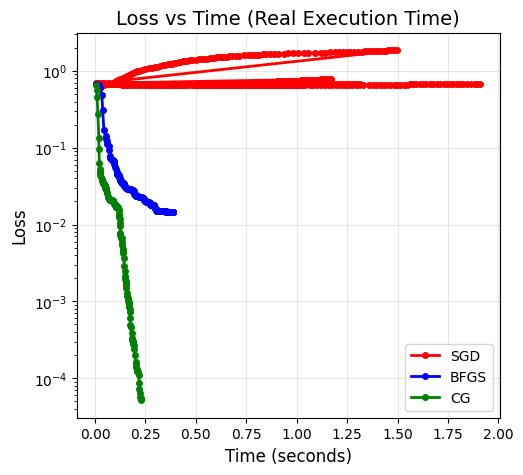

In [28]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for method, color in zip(['SGD', 'BFGS', 'CG'], ['red', 'blue', 'green']):
    if results[method]['time_history']:
        plt.plot(results[method]['time_history'], 
                results[method]['loss_history'], 
                'o-', linewidth=2, markersize=4, label=method, color=color)

plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss vs Time (Real Execution Time)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')


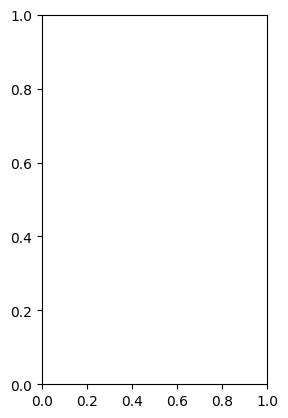

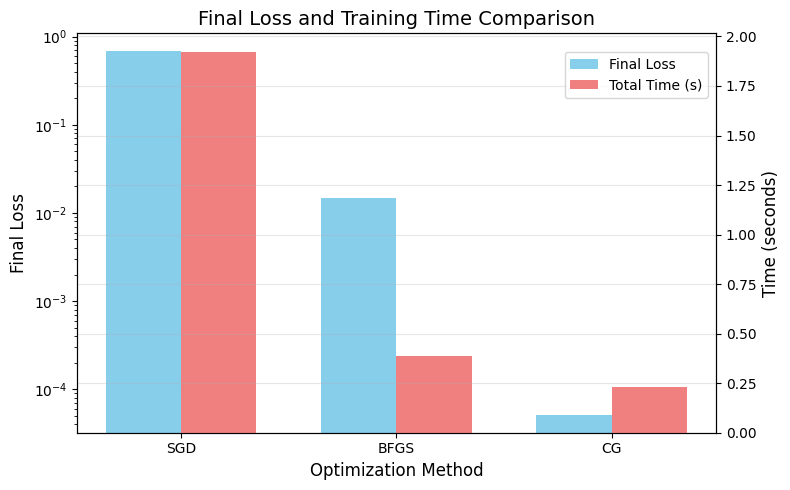

In [30]:

plt.subplot(1, 2, 2)
methods = ['SGD', 'BFGS', 'CG']
final_losses = [results[m]['final_loss'] for m in methods]
times = [sgd_time, bfgs_time, cg_time]

x = np.arange(len(methods))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 5))
bars1 = ax1.bar(x - width/2, final_losses, width, label='Final Loss', color='skyblue')
ax1.set_xlabel('Optimization Method', fontsize=12)
ax1.set_ylabel('Final Loss', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(methods)
ax1.set_yscale('log')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, times, width, label='Total Time (s)', color='lightcoral')
ax2.set_ylabel('Time (seconds)', fontsize=12)

plt.title('Final Loss and Training Time Comparison', fontsize=14)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

plt.show()


In [31]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28*28).astype('float32') / 255.0

model = models.Sequential([
    layers.Dense(100, activation='relu', input_shape=(784,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 20s 2us/step


C:\Users\Reza\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,710 (389.49 KB)

 Trainable params: 99,710 (389.49 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
import numpy as np

N = 99710
print(f"\n1. Total parameters in model (N): {N:,}")
hessian_elements = N * N
print(f"2. Hessian matrix size: {N:,} × {N:,} = {hessian_elements:.2e} elements")

memory_bytes = hessian_elements * 4
memory_kb = memory_bytes / 1024
memory_mb = memory_kb / 1024
memory_gb = memory_mb / 1024

print(f"\n3. Memory required to store Hessian matrix:")
print(f"   - Bytes:  {memory_bytes:.2e}")
print(f"   - KB:     {memory_kb:.2e}")
print(f"   - MB:     {memory_mb:.2e}")
print(f"   - GB:     {memory_gb:.2f}")


1. Total parameters in model (N): 99,710
2. Hessian matrix size: 99,710 × 99,710 = 9.94e+09 elements

3. Memory required to store Hessian matrix:
   - Bytes:  3.98e+10
   - KB:     3.88e+07
   - MB:     3.79e+04
   - GB:     37.04


In [33]:

X_train = X_train.reshape(-1, 28*28).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28*28).astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

X_train_small = X_train[:10000]
y_train_small = y_train[:10000]


def create_model(optimizer):
    model = models.Sequential([
        layers.Dense(100, activation='relu', input_shape=(784,)),
        layers.Dense(100, activation='relu'),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

sgd_model = create_model('sgd')
sgd_start = time.time()
sgd_history = sgd_model.fit(X_train_small, y_train_small,
                            epochs=20,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=0)
sgd_time = time.time() - sgd_start
sgd_val_loss = sgd_history.history['val_loss'][-1]

adam_model = create_model('adam')
adam_start = time.time()
adam_history = adam_model.fit(X_train_small, y_train_small,
                              epochs=20,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=0)
adam_time = time.time() - adam_start
adam_val_loss = adam_history.history['val_loss'][-1]

print("RESULTS:")
print("="*60)
print(f"SGD  - Final validation loss: {sgd_val_loss:.4f}, Time: {sgd_time:.1f}s")
print(f"Adam - Final validation loss: {adam_val_loss:.4f}, Time: {adam_time:.1f}s")

if adam_val_loss < sgd_val_loss:
    print(f"Adam converges to lower loss ({adam_val_loss/sgd_val_loss:.1%} of SGD loss)")
else:
    print(f"SGD converges to lower loss")


RESULTS:
SGD  - Final validation loss: 2.2976, Time: 46.2s
Adam - Final validation loss: 0.3332, Time: 42.2s
Adam converges to lower loss (14.5% of SGD loss)


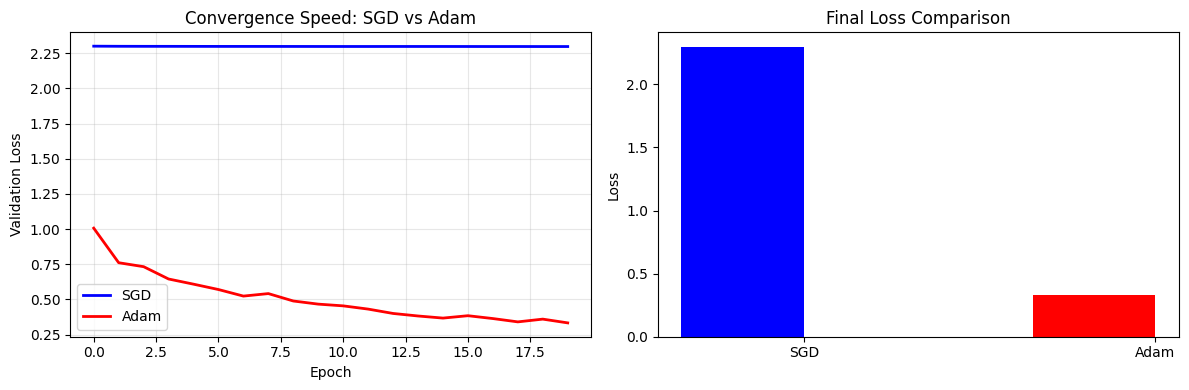

In [34]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(sgd_history.history['val_loss'], 'b-', linewidth=2, label='SGD')
plt.plot(adam_history.history['val_loss'], 'r-', linewidth=2, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Convergence Speed: SGD vs Adam')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
methods = ['SGD', 'Adam']
final_losses = [sgd_val_loss, adam_val_loss]
times = [sgd_time, adam_time]

x = np.arange(len(methods))
width = 0.35

plt.bar(x - width/2, final_losses, width, label='Final Loss', color=['blue', 'red'])
plt.ylabel('Loss')
plt.title('Final Loss Comparison')
plt.xticks(x, methods)

plt.tight_layout()
plt.show()

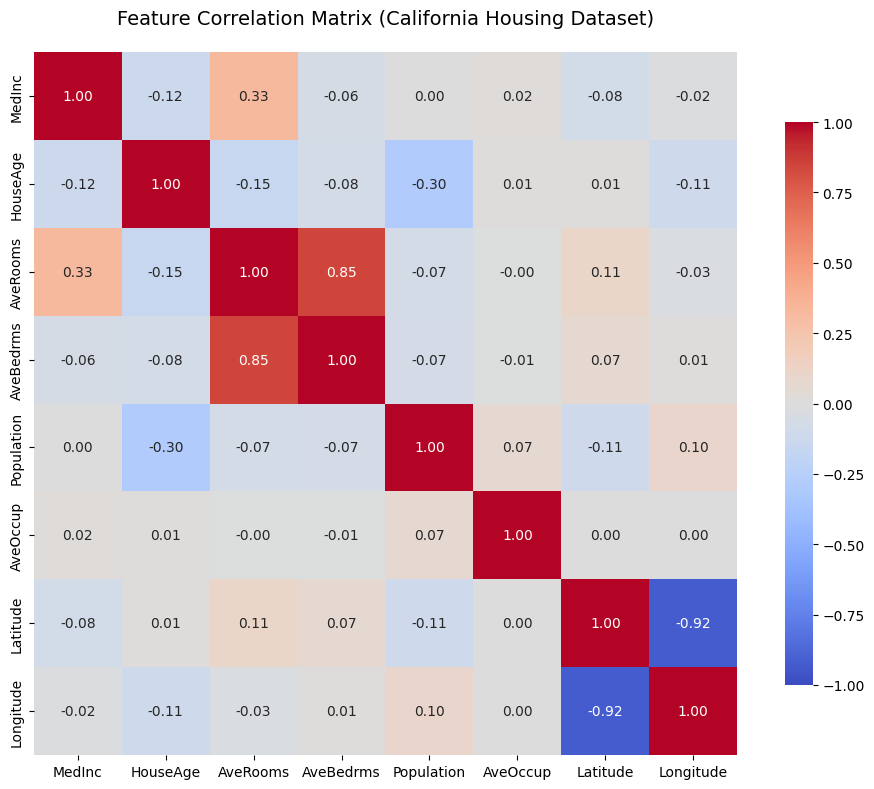

   AveRooms        ↔ AveBedrms      :   0.848
   Latitude        ↔ Longitude      :  -0.925


In [5]:
import seaborn as sns
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

california = fetch_california_housing()
X = california.data
y = california.target
feature_names = california.feature_names
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

correlation_matrix = np.corrcoef(X_scaled, rowvar=False)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            square=True,
            xticklabels=feature_names,
            yticklabels=feature_names,
            cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix (California Housing Dataset)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

strong_corr_count = 0
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        corr = correlation_matrix[i, j]
        if abs(corr) > 0.7:
            strong_corr_count += 1
            print(f"   {feature_names[i]:15s} ↔ {feature_names[j]:15s}: {corr:7.3f}")

In [7]:
Q, R = np.linalg.qr(X_scaled, mode='reduced')
QtQ = Q.T @ Q

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

sgd_original = SGDRegressor(
    max_iter=1,
    tol=None,
    learning_rate='constant',
    eta0=0.01,
    random_state=42,
    warm_start=True
)
original_losses = []
sgd_original.fit(X_scaled[:100], y[:100])

for epoch in range(100):
    sgd_original.fit(X_scaled, y)
    y_pred = sgd_original.predict(X_scaled)
    loss = mean_squared_error(y, y_pred)
    original_losses.append(loss)
    
    if epoch % 20 == 0:
        print(f"   Epoch {epoch:3d}: Loss = {loss:.6f}")

print(f"Final loss (original features): {original_losses[-1]:.6f}")

sgd_orthogonal = SGDRegressor(
    max_iter=1,
    tol=None,
    learning_rate='constant',
    eta0=0.01,
    random_state=42,
    warm_start=True
)

orthogonal_losses = []
sgd_orthogonal.fit(Q[:100], y[:100])

for epoch in range(100):
    sgd_orthogonal.fit(Q, y)
    y_pred_q = sgd_orthogonal.predict(Q)
    loss_q = mean_squared_error(y, y_pred_q)
    orthogonal_losses.append(loss_q)
    
    if epoch % 20 == 0:
        print(f"   Epoch {epoch:3d}: Loss = {loss_q:.6f}")

print(f"Final loss (orthogonal features): {orthogonal_losses[-1]:.6f}")



   Epoch   0: Loss = 232408337.590939
   Epoch  20: Loss = 449641865321112915673088.000000
   Epoch  40: Loss = 449641865321112915673088.000000
   Epoch  60: Loss = 449641865321112915673088.000000
   Epoch  80: Loss = 449641865321112915673088.000000
Final loss (original features): 449641865321112915673088.000000
   Epoch   0: Loss = 1.317389
   Epoch  20: Loss = 1.102270
   Epoch  40: Loss = 0.999916
   Epoch  60: Loss = 0.948627
   Epoch  80: Loss = 0.922062
Final loss (orthogonal features): 0.908540


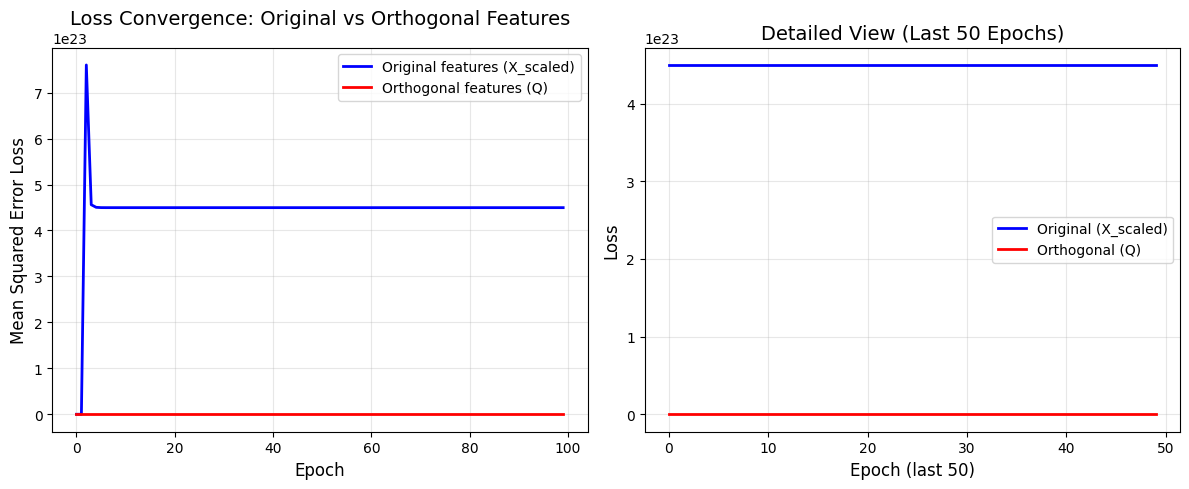

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(original_losses, 'b-', linewidth=2, label='Original features (X_scaled)')
plt.plot(orthogonal_losses, 'r-', linewidth=2, label='Orthogonal features (Q)')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error Loss', fontsize=12)
plt.title('Loss Convergence: Original vs Orthogonal Features', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(original_losses[-50:], 'b-', linewidth=2, label='Original (X_scaled)')
plt.plot(orthogonal_losses[-50:], 'r-', linewidth=2, label='Orthogonal (Q)')
plt.xlabel('Epoch (last 50)', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Detailed View (Last 50 Epochs)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()